# Importing Packages

# Pre-processing

## Remove rows with missing IC50

In [4]:
import pandas as pd
import numpy as np
import pickle

organism = 'Target Source Organism According to Curator or DataSource'
chain = 'BindingDB Target Chain Sequence'
multichain = 'Number of Protein Chains in Target (>1 implies a multichain complex)'
cols = [organism, chain, multichain, 'Target Name', 'IC50 (nM)', 'Ligand SMILES', 'BindingDB Ligand Name', 'Ligand InChI Key']


path = r'BindingDB_BindingDB_Articles_202310.tsv'
df = pd.read_csv(path, delimiter='\t', usecols=range(50))
length_filter = df[chain].str.len() <= 1000                 # remove very long protein sequence

df = df[~df['IC50 (nM)'].isna() & length_filter][cols].drop_duplicates().reset_index(drop=True)
df = df.reset_index(drop=True)
df['is_viral_protein'] = df[organism].str.lower().str.contains('virus')

df['IC50 (nM)'] = df['IC50 (nM)'].str.strip()

df['IC50_nM_cleaned'] = df['IC50 (nM)'].str.replace('[><]','', regex=True).astype(float)
df.loc[df['IC50 (nM)'].str.contains('>'), 'IC50_nM_cleaned'] = df[df['IC50 (nM)'].str.contains('>')]['IC50_nM_cleaned'] - 0.5

df['is_IC50_below_10_nM'] = df['IC50_nM_cleaned'] < 10
df['is_IC50_below_100_nM'] = df['IC50_nM_cleaned'] < 100

# df['Ki_nM_cleaned'] = df['Ki (nM)'].str.replace('[><]','', regex=True).astype(float)
# df.loc[df['Ki (nM)'].fillna('').str.contains('>'), 'Ki_nM_cleaned'] = df[df['Ki (nM)'].fillna('').str.contains('>')]['Ki_nM_cleaned'] - 0.5
df.to_csv('BindingDB_ligand_target_IC50_cleaned.csv', index=False)
df.head()

C:\Users\mdhya\AppData\Local\Temp\ipykernel_10304\2833636289.py:12: DtypeWarning: Columns (10,13) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path, delimiter='\t', usecols=range(50))


,Target Source Organism According to Curator or DataSource,BindingDB Target Chain Sequence,Number of Protein Chains in Target (>1 implies a multichain complex),Target Name,IC50 (nM),Ligand SMILES,BindingDB Ligand Name,Ligand InChI Key,is_viral_protein,IC50_nM_cleaned,is_IC50_below_10_nM,is_IC50_below_100_nM
0,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,8.7,COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCCCN1CCN(C)...,3-quinolinecarbonitrile 3::4-Phenylamino-3-qui...,MVQUQGLRQPMJPU-UHFFFAOYSA-N,NaN,8.7,True,True
1,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,5.1,COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(cnc2cc1OCCCN1...,3-quinolinecarbonitrile 4::6-methoxy-7-[3-(4-m...,VOUVVBUKNLBXGS-UHFFFAOYSA-N,NaN,5.1,True,True
2,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,2.8,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1O...,"3-quinolinecarbonitrile 8::4-[(2,4-dichloro-5-...",VXEOIAFZWQMOEP-UHFFFAOYSA-N,NaN,2.8,True,True
3,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,12,COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OCCOC,"3-quinolinecarbonitrile 9::4-[(2,4-dichlorophe...",DTLASHUZTAPRBX-UHFFFAOYSA-N,NaN,12.0,False,True
4,NaN,MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADG...,1,Proto-oncogene tyrosine-protein kinase Src,25,COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc...,"3-quinolinecarbonitrile 10::6,7-bis(2-methoxye...",BTBPPLGKNLXRGR-UHFFFAOYSA-N,NaN,25.0,False,True


In [4]:
df['is_IC50_above_1_nM'].value_counts()

is_IC50_above_1_nM
True     47721
False     1019
Name: count, dtype: int64

In [5]:
df['is_IC50_above_10_nM'].value_counts()

is_IC50_above_10_nM
True     43577
False     5163
Name: count, dtype: int64

## RdKit molecular descriptor

In [41]:
# augDF['Ligand SMILES']
m = ''.join(augDF['Ligand SMILES'].values.tolist())
m2 = list(set(m))
len(m2)
# set()
# d = {}
# for i, symbol in enumerate(m2):
#     d[symbol] = i+34
# d

48

In [43]:
[x for x in m2 if x not in SMILES_dict]

['X', 'L', 'g', 'K', 'M']

In [44]:
augDF[augDF['Ligand SMILES'].str.contains('M')]['Ligand SMILES']

2299          O=C([O-])[C@H]([O-])c1ccccc1.[Mg+2]
10668                             [Mg+2].[O-][O-]
19675    O=[N+]([O-])[O-].O=[N+]([O-])[O-].[Mg+2]
20041                                      O=[Mg]
25552                                      [MgH2]
29505                    O=S(=O)([O-])[O-].[Mg+2]
36497                                      [MgH2]
47274                CC(=O)[O-].CC(=O)[O-].[Mg+2]
49559         O=C([O-])[C@H]([O-])c1ccccc1.[Mg+2]
Name: Ligand SMILES, dtype: object

In [25]:
m = ''.join(df['Ligand SMILES'].values.tolist())
m2 = list(set(m))
len(m2)
# set()
d = {}
for i, symbol in enumerate(m2):
    d[symbol] = i+34
d

{'l': 34,
 'i': 35,
 'P': 36,
 'V': 37,
 'a': 38,
 '6': 39,
 '7': 40,
 '\\': 41,
 'N': 42,
 'e': 43,
 'n': 44,
 ')': 45,
 '8': 46,
 'c': 47,
 '5': 48,
 '[': 49,
 'd': 50,
 '2': 51,
 'o': 52,
 '9': 53,
 ']': 54,
 's': 55,
 '1': 56,
 '.': 57,
 '4': 58,
 '-': 59,
 '=': 60,
 't': 61,
 'R': 62,
 '3': 63,
 'H': 64,
 'I': 65,
 'G': 66,
 'b': 67,
 'C': 68,
 'S': 69,
 '+': 70,
 'B': 71,
 '#': 72,
 'Z': 73,
 '@': 74,
 '(': 75,
 'u': 76,
 '/': 77,
 'F': 78,
 '0': 79,
 'A': 80,
 '%': 81,
 'O': 82,
 'r': 83}

In [11]:
fp = pd.read_csv('morgan_fingerprints.csv')
fp_dict = {k:v for k,v in zip(fp['SMILES'], fp.iloc[:,2:].values)}
fp_dict

{'COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCCCN1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(cnc2cc1OCCCN1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc(Nc2c(cnc3cc(OCC4CCN(C)CC4)c(OC)cc23)C#N)c(Cl)cc1Cl': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCC1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=i

In [16]:

with open('morgan_fingerprints_nBits2048_radius3.pkl', 'wb') as f:
    pickle.dump(fp_dict, f, protocol=pickle.HIGHEST_PROTOCOL)

In [2]:
with open('morgan_fingerprints_nBits2048_radius3.pkl', 'rb') as f:
    fp_dict = pickle.load(f)
fp_dict

{'COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCCCN1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc2c(Nc3cc(OC)c(OC)c(OC)c3)c(cnc2cc1OCCCN1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc1OCCOC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(Cl)cc3Cl)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3ccc(Cl)cc3Cl)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COCCOc1cc2ncc(C#N)c(Nc3cc(OC)c(OC)c(OC)c3)c2cc1OC': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc(Nc2c(cnc3cc(OCC4CCN(C)CC4)c(OC)cc23)C#N)c(Cl)cc1Cl': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'COc1cc2c(Nc3ccc(Cl)cc3Cl)c(cnc2cc1OCC1CCN(C)CC1)C#N': array([0, 0, 0, ..., 0, 0, 0], dtype=i

In [19]:
vA = fp_dict['Cc1[nH]c2ccccc2c1CCNCc1ccc(\C=C\C(=O)NO)cc1'] 
vB = fp_dict['Cc1[nH]c2ccccc2c1CCNCc1ccc(C=CC(=O)NO)cc1']

np.dot(vA,vB) / (np.linalg.norm(vA) * np.linalg.norm(vB))

1.0

## UMAP of Morgan Fingerprints

In [1]:
from umap import UMAP 
from ligand_target import get_morgan_fp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors

umap_red = UMAP(n_neighbors=100, n_components=2)

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
# get only ligands that were tested for IC50 against viral proteins
df = pd.read_csv('BindingDB_ligand_target_IC50_cleaned.csv')
virusDF = df[df.is_viral_protein==1]
virusDF_ligands = virusDF['Ligand SMILES'].unique()
len(virusDF_ligands)

3107

In [17]:
morgan_fps = get_morgan_fp(virusDF_ligands)
morgan_fps.shape

(3107, 2048)

In [18]:
umap_red = UMAP(n_neighbors=100, n_components=2)
morgan_fps_umap2 = umap_red.fit_transform(morgan_fps)
morgan_fps_umap2

array([[12.500096 ,  8.441622 ],
       [12.503832 ,  8.481158 ],
       [12.41688  ,  8.466448 ],
       ...,
       [ 6.8719497,  7.237154 ],
       [ 6.179403 ,  7.946804 ],
       [ 6.1882358,  7.9217043]], dtype=float32)

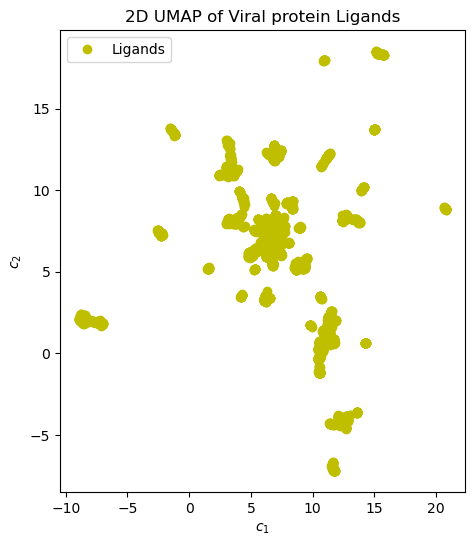

In [28]:
plt.figure(figsize = (12, 6))

plt.subplot(122)
plt.plot(morgan_fps_umap2[:, 0], morgan_fps_umap2[:, 1], 'yo', label = 'Ligands')
# plt.plot(X_95[:, 0][y_wine == 1], X_95[:, 1][y_wine == 1], 'bs', label = 'Cultivar 2')
# plt.plot(X_95[:, 0][y_wine == 2], X_95[:, 1][y_wine == 2], 'g^', label = 'Cultivar 3')
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('2D UMAP of Viral protein Ligands')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
plt.savefig('UMAP_before_clustering.png')
plt.show()

<Figure size 640x480 with 0 Axes>

### Clustering

In [21]:
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from collections import Counter

clustering_algo = HDBSCAN(cluster_selection_epsilon=1)
clusters = clustering_algo.fit_predict(morgan_fps_umap2) 
clusters

array([ 9,  9,  9, ..., 21, 21, 21], dtype=int64)

In [22]:
cluster_stats = Counter(clusters)
cluster_stats

Counter({21: 1213,
         16: 375,
         0: 198,
         12: 163,
         9: 144,
         14: 142,
         18: 132,
         19: 99,
         10: 88,
         3: 79,
         11: 77,
         5: 71,
         6: 61,
         8: 47,
         1: 36,
         17: 33,
         4: 30,
         2: 29,
         20: 28,
         15: 24,
         7: 22,
         13: 16})

C:\Users\mdhya\AppData\Local\Temp\ipykernel_19396\1279395560.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(morgan_fps_umap2[:, 0][clusters==cluster_num], morgan_fps_umap2[:, 1][clusters==cluster_num], 'yo', c=color_set[cluster_num], label = str(cluster_num))


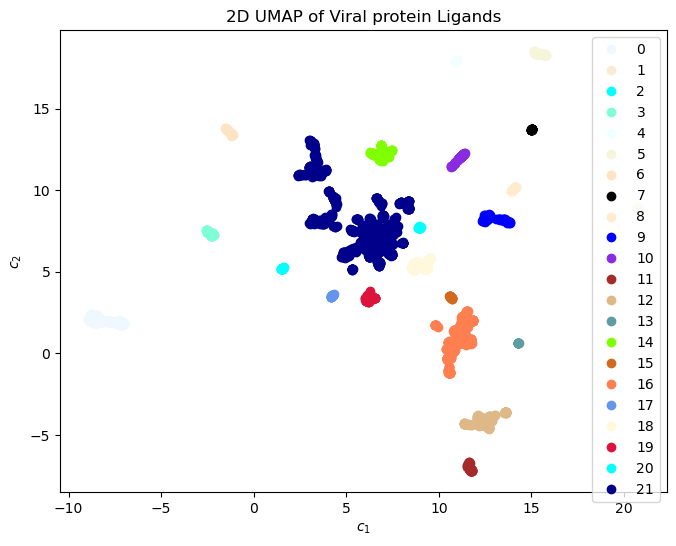

In [27]:
color_set = [x for x in mcolors.CSS4_COLORS.keys()]
plt.figure(figsize = (18, 6))

plt.subplot(122)
for cluster_num in range(max(clusters)+1):
    plt.plot(morgan_fps_umap2[:, 0][clusters==cluster_num], morgan_fps_umap2[:, 1][clusters==cluster_num], 'yo', c=color_set[cluster_num], label = str(cluster_num))

plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('2D UMAP of Viral protein Ligands')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
plt.savefig('UMAP_after_clustering.png')
plt.show()

## UMAP of ESM hidden states

In [7]:
import torch 
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, EsmForSequenceClassification, EsmConfig, EsmModel

device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
esm_model = EsmModel.from_pretrained("facebook/esm2_t12_35M_UR50D").to(device)


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [31]:
print(proteinDF.shape, len(targets))

(1305, 2) 1296


In [32]:
proteinDF = df[['BindingDB Target Chain Sequence', 'is_viral_protein']].sort_values('is_viral_protein', ascending=False)
proteinDF = proteinDF.drop_duplicates('BindingDB Target Chain Sequence', keep='first').reset_index(drop=True)
targets = proteinDF['BindingDB Target Chain Sequence'].unique()
protein_hidden_states = torch.ones((len(targets),480))
for idx, target in tqdm(enumerate(targets)):
    with torch.no_grad():
        protein_inputs = tokenizer([target], return_tensors="pt", padding='max_length', max_length=1001).to(device)
        output = esm_model(**protein_inputs, output_hidden_states=True)
        hstate = torch.mean(output.hidden_states[12], dim=1).cpu()
        protein_hidden_states[idx] = hstate

# protein_hidden_states[0]

0it [00:00, ?it/s]

In [9]:
protein_hidden_states[0].shape

torch.Size([480])

In [34]:
protein_embeddings = protein_hidden_states.numpy()
protein_embeddingsDF = pd.DataFrame(protein_embeddings)
protein_embeddingsDF = pd.concat([proteinDF, protein_embeddingsDF], axis=1)
protein_embeddingsDF['is_viral_protein'] = protein_embeddingsDF['is_viral_protein'].fillna(False)
protein_embeddingsDF.to_csv('protein_esm35M_embeddings_mean.csv', index=False)
protein_embeddingsDF

,BindingDB Target Chain Sequence,is_viral_protein,0,1,2,3,4,5,6,7,...,470,471,472,473,474,475,476,477,478,479
0,MNPNQKIITIGSICLVVGLISLILQIGNIISIWISHSIQTGSQNHT...,True,-0.119456,0.106443,0.167773,0.116885,0.178502,-0.141477,-0.191864,-0.103651,...,-0.100861,-0.017724,-0.083286,0.169029,0.274206,0.129172,0.310787,-0.283817,-0.015027,0.047859
1,EVKTIKVFTTVDNTNLHTQLVDMSMTYGQQFGPTYLDGADVTKIKP...,True,-0.083973,0.040937,0.053236,-0.021503,0.138304,-0.058994,-0.186995,-0.226695,...,-0.006807,0.030496,-0.002511,0.108464,0.134496,-0.067310,0.057684,-0.326182,-0.084196,-0.024880
2,IERTADITWESDAEITGSSERVDVRLDDDGNFQLMNDPGA,True,-0.081268,0.224345,0.078960,0.070472,0.303089,-0.045819,-0.415119,-0.300988,...,-0.226957,0.131129,-0.099584,0.231148,0.352449,0.079763,0.352484,-0.299378,0.080140,0.066362
3,PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKM...,True,-0.126198,0.051505,0.166644,0.058957,0.285294,-0.046758,-0.090515,-0.307012,...,-0.088588,0.015061,-0.163432,0.134573,0.470655,0.079583,0.361915,-0.428634,0.018311,-0.102267
4,PQITLWQRPLVTVKIGGQLREALLDTGADDTVLEDINLPGKWKPKM...,True,-0.126450,0.025234,0.184013,0.056266,0.296284,-0.040904,-0.088113,-0.308196,...,-0.054154,0.007862,-0.156765,0.156636,0.475756,0.077810,0.343112,-0.414634,0.003047,-0.074208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291,MSKPQPIAAANWKCNGSQQSLSELIDLFNSTSINHDVQCVVASTFV...,False,-0.151029,-0.042000,0.075670,0.174886,0.391694,-0.208241,-0.199150,-0.101679,...,0.113462,-0.040554,-0.186615,0.303816,0.294439,0.167745,0.144484,-0.204774,-0.033550,-0.079904
1292,MSGDHLHNDSQIEADFRLNDSHKHKDKHKDREHRHKEHKKEKDREK...,False,-0.114826,-0.075025,0.153451,-0.041230,-0.054212,-0.029818,-0.229735,-0.102985,...,0.021262,0.031736,0.103744,0.206284,0.003599,-0.099643,0.075892,-0.121090,-0.022882,-0.020470
1293,MKGKLLKGVLSLGVGLGALYSGTSAQAEASTNQNDTLKVMTHNVYM...,False,-0.204620,0.006822,0.201168,0.156564,0.322137,-0.118905,-0.207561,0.015324,...,-0.029659,-0.006273,-0.117712,0.088373,0.381671,0.200451,0.197490,-0.298828,0.077496,-0.017704
1294,SGFRKMAFPSGKVEGCMVQVTCGTTTLNGLWLDDVVYCPRHVICTS...,False,-0.096550,0.061825,0.038699,0.089197,0.129837,-0.022963,-0.191445,-0.220731,...,-0.038316,0.035892,-0.076644,0.100298,0.104768,-0.049375,0.182228,-0.279462,-0.080721,0.033111


In [ ]:
umap_red = UMAP(n_neighbors=15, n_components=2)
esm_emb_umap2 = umap_red.fit_transform(protein_embeddingsDF[protein_embeddingsDF.is_viral_protein].iloc[:,2:])
esm_emb_umap2

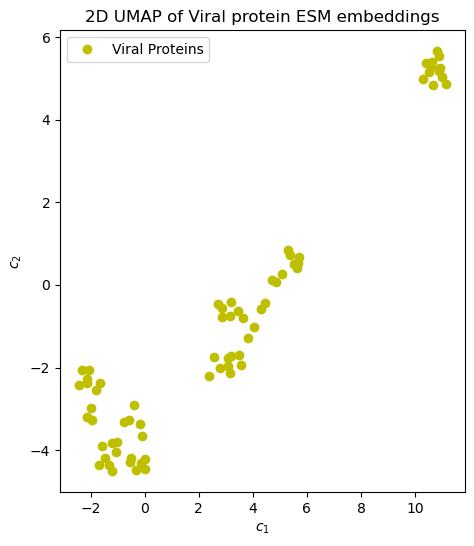

In [36]:
plt.figure(figsize = (12, 6))

plt.subplot(122)
plt.plot(esm_emb_umap2[:, 0], esm_emb_umap2[:, 1], 'yo', label = 'Viral Proteins')
# plt.plot(X_95[:, 0][y_wine == 1], X_95[:, 1][y_wine == 1], 'bs', label = 'Cultivar 2')
# plt.plot(X_95[:, 0][y_wine == 2], X_95[:, 1][y_wine == 2], 'g^', label = 'Cultivar 3')
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('2D UMAP of Viral protein ESM embeddings')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
plt.savefig('esm_embeddings__UMAP_before_clustering.png')
plt.show()

In [ ]:
umap_red_2 = UMAP(n_neighbors=15, n_components=2)
esm_emb_umap2_all_proteins = umap_red_2.fit_transform(protein_embeddingsDF.iloc[:,2:])

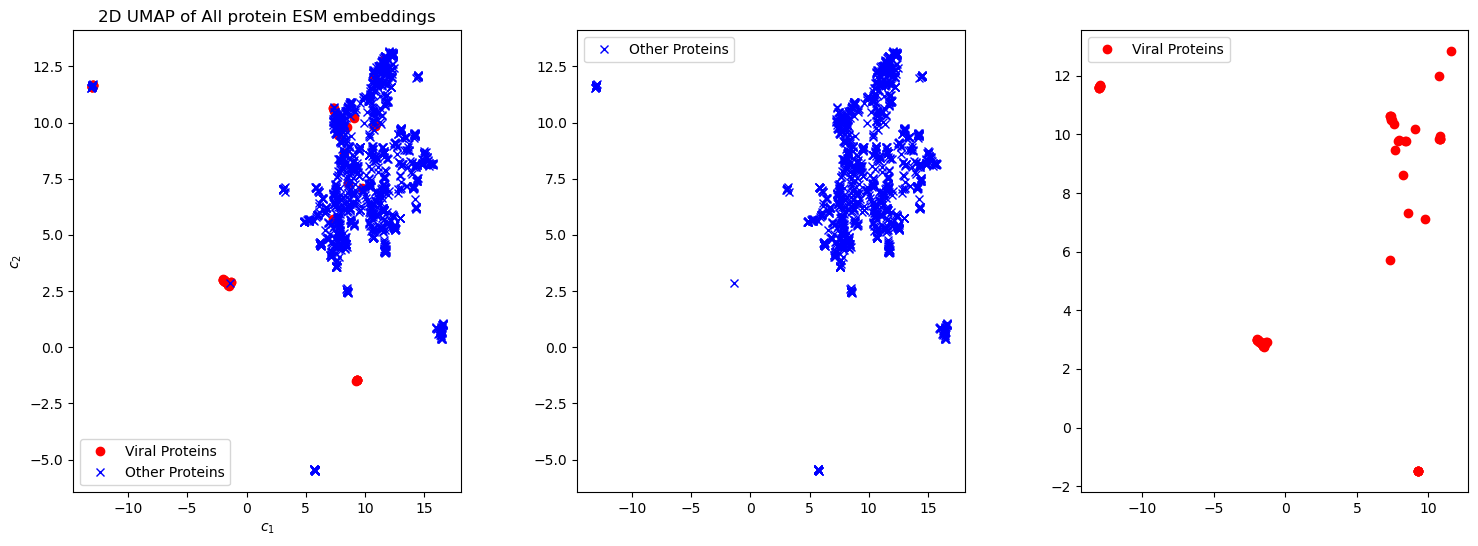

In [54]:
plt.figure(figsize = (18, 6))

plt.subplot(133)
plt.plot(esm_emb_umap2_all_proteins[protein_embeddingsDF.is_viral_protein][:, 0], esm_emb_umap2_all_proteins[protein_embeddingsDF.is_viral_protein][:, 1], 'ro', label = 'Viral Proteins')
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.subplot(132)
plt.plot(esm_emb_umap2_all_proteins[~protein_embeddingsDF.is_viral_protein][:, 0], esm_emb_umap2_all_proteins[~protein_embeddingsDF.is_viral_protein][:, 1], 'bx', label = 'Other Proteins')
plt.legend(loc = 'best', shadow = False, scatterpoints = 1)

plt.subplot(131)
plt.plot(esm_emb_umap2_all_proteins[protein_embeddingsDF.is_viral_protein][:, 0], esm_emb_umap2_all_proteins[protein_embeddingsDF.is_viral_protein][:, 1], 'ro', label = 'Viral Proteins')
plt.plot(esm_emb_umap2_all_proteins[~protein_embeddingsDF.is_viral_protein][:, 0], esm_emb_umap2_all_proteins[~protein_embeddingsDF.is_viral_protein][:, 1], 'bx', label = 'Other Proteins')
plt.legend(loc = 'lower left', shadow = False, scatterpoints = 1)

plt.title('2D UMAP of All protein ESM embeddings')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
plt.savefig('all_proteins_esm_embeddings__UMAP_before_clustering.png')
plt.show()

### Clustering

In [37]:
from hdbscan import HDBSCAN
from sklearn.cluster import KMeans
from collections import Counter

clustering_algo = HDBSCAN(cluster_selection_epsilon=0.1)
clusters = clustering_algo.fit_predict(esm_emb_umap2) 
clusters

array([2, 2, 2, 2, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 2, 2, 2, 2, 2, 2, 0, 2,
       0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 2, 2, 2, 0, 2, 2, 1, 1, 0, 0,
       0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 1,
       1, 1, 1, 1], dtype=int64)

C:\Users\mdhya\AppData\Local\Temp\ipykernel_15856\613189793.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "yo" (-> color='y'). The keyword argument will take precedence.
  plt.plot(esm_emb_umap2[:, 0][clusters==cluster_num], esm_emb_umap2[:, 1][clusters==cluster_num], 'yo', c=color_set[cluster_num], label = str(cluster_num))


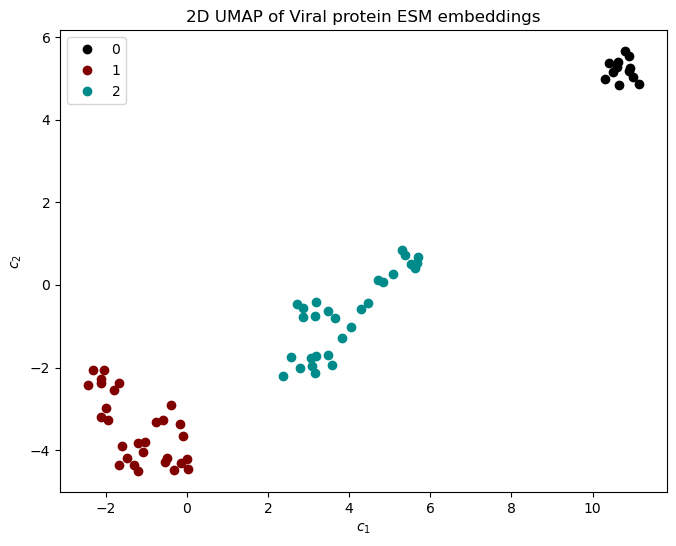

In [38]:
color_set = ['black', 'maroon', 'darkcyan', 'darkorchid']
plt.figure(figsize = (18, 6))

plt.subplot(122)
for cluster_num in range(max(clusters)+1):
    plt.plot(esm_emb_umap2[:, 0][clusters==cluster_num], esm_emb_umap2[:, 1][clusters==cluster_num], 'yo', c=color_set[cluster_num], label = str(cluster_num))

plt.legend(loc = 'best', shadow = False, scatterpoints = 1)
plt.title('2D UMAP of Viral protein ESM embeddings')
plt.xlabel('$c_1$')
plt.ylabel('$c_2$')

plt.subplots_adjust(wspace = 0.3)
plt.savefig('esm_embeddings__UMAP_after_clustering.png')
plt.show()

## Augment Negative Example

In [55]:
chembl = pd.read_csv('CHEMBL_200_new.csv', sep = ';')
chembl = chembl.rename(columns={'Inchi Key':'Ligand InChI Key', 'Smiles':'Ligand SMILES'})
chembl = chembl[~chembl['Ligand InChI Key'].isin(df['Ligand InChI Key'].unique())]
chembl = chembl.drop_duplicates(subset='Ligand InChI Key').reset_index(drop=True)
chembl

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Np Likeness Score,Molecular Species,Molecular Formula,Ligand SMILES,Ligand InChI Key
0,CHEMBL1964670,NaN,NaN,Small molecule,NaN,132.16,53.0,53.0,0.32,46.53,...,9.0,3.0,1.0,0.0,132.0786,0.45,NEUTRAL,C6H12O3,CCOC(=O)CCCO,AYPJVXQBVHCUCJ-UHFFFAOYSA-N
1,CHEMBL1162361,NaN,3-Fluoro-Pyridinium,Small molecule,NaN,97.09,1.0,1.0,1.22,12.89,...,7.0,1.0,0.0,0.0,97.0328,-2.20,NEUTRAL,C5H4FN,Fc1cccnc1,CELKOWQJPVJKIL-UHFFFAOYSA-N
2,CHEMBL4093989,NaN,NaN,Small molecule,NaN,179.22,1.0,3.0,1.57,52.32,...,13.0,3.0,2.0,0.0,179.0946,-1.14,NEUTRAL,C10H13NO2,CC(C)Oc1ccccc1C(N)=O,BTHLVVULQLRTBK-UHFFFAOYSA-N
3,CHEMBL1486321,NaN,NaN,Small molecule,NaN,118.14,2.0,2.0,-1.38,75.35,...,8.0,4.0,4.0,0.0,118.0742,1.31,ZWITTERION,C4H10N2O2,CNCC(N)C(=O)O,UJVHVMNGOZXSOZ-UHFFFAOYSA-N
4,CHEMBL1337040,NaN,NaN,Small molecule,NaN,178.57,4.0,5.0,-0.26,84.91,...,11.0,5.0,3.0,0.0,178.0145,0.61,ACID,C5H7ClN2O3,NC(C(=O)O)C1CC(Cl)=NO1,QAWIHIJWNYOLBE-UHFFFAOYSA-N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40300,CHEMBL160464,NaN,NaN,Small molecule,NaN,163.24,1.0,7.0,1.85,16.13,...,12.0,2.0,0.0,0.0,162.1157,-0.78,BASE,C10H14N2,[2H][C@H]1CC[C@@H](c2ccccn2)N1C,AQCRXZYYMOXFAN-AYZPNVOZSA-N
40301,CHEMBL1963329,NaN,NaN,Small molecule,NaN,190.25,NaN,NaN,1.56,35.64,...,14.0,4.0,0.0,0.0,190.1218,-1.20,NEUTRAL,C10H14N4,c1cn(CCCCn2ccnc2)cn1,LGCPYQSYWVJQCJ-UHFFFAOYSA-N
40302,CHEMBL2332208,NaN,NaN,Small molecule,NaN,195.24,1.0,1.0,1.73,16.38,...,14.0,2.0,0.0,0.0,195.1059,-1.40,NEUTRAL,C11H14FNO,C#CCN(C)[C@H](C[19F])Cc1ccco1,XBKZEROHOXZUGT-SOLGNKEASA-N
40303,CHEMBL3350386,NaN,NaN,Small molecule,NaN,130.14,1.0,2.0,0.15,57.53,...,9.0,3.0,2.0,0.0,128.0473,2.27,ACID,C6H8O3,[3H]C1(O)C=C(C(=O)O)CC1,VKJGQKRRULDFCI-XHHURNKPSA-N


In [54]:
proteins = df[chain].unique()
proteins

array(['MGSNKSKPKDASQRRRSLEPAENVHGAGGGAFPASQTPSKPASADGHRGPSAAFAPAAAEPKLFGGFNSSDTVTSPQRAGPLAGGVTTFVALYDYESRTETDLSFKKGERLQIVNNTEGDWWLAHSLSTGQTGYIPSNYVAPSDSIQAEEWYFGKITRRESERLLLNAENPRGTFLVRESETTKGAYCLSVSDFDNAKGLNVKHYKIRKLDSGGFYITSRTQFNSLQQLVAYYSKHADGLCHRLTTVCPTSKPQTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKTLKPGTMSPEAFLQEAQVMKKLRHEKLVQLYAVVSEEPIYIVTEYMSKGSLLDFLKGETGKYLRLPQLVDMAAQIASGMAYVERMNYVHRDLRAANILVGENLVCKVADFGLARLIEDNEYTARQGAKFPIKWTAPEAALYGRFTIKSDVWSFGILLTELTTKGRVPYPGMVNREVLDQVERGYRMPCPPECPESLHDLMCQCWRKEPEERPTFEYLQAFLEDYFTSTEPQYQPGENL',
       'MNPNQKIITIGSICLVVGLISLILQIGNIISIWISHSIQTGSQNHTGICNQNIITYKNSTWVKDTTSVILTGNSSLCPIRGWAIYSKDNSIRIGSKGDVFVIREPFISCSHLECRTFFLTQGALLNDKHSNGTVKDRSPYRALMSCPVGEAPSPYNSRFESVAWSASACHDGMGWLTIGISGPDNGAVAVLKYNGIITETIKSWRKKILRTQESECACVNGSCFTIMTDGPSDGLASYKIFKIEKGKVTKSIELNAPNSHYEECSCYPDTGKVMCVCRDNWHGSNRPWVSFDQNLDYQIGYICSGVFGDNPRPEDGTGSCGPVYVDGANGVKGFSYRYGNGVWIGRTKSHSSRHGFEMIWDPNGWTETDSKFSVRQDVVAMTDWSGYSGSFVQHPELTGLDCMRPCFWVELIRGRPKEKTIWTSASSISFCGVNSDTVDWSWPDG

In [52]:
np.random.randint(low=0, high=chembl.shape[0], size=50000)

array([ 1564,  1491, 34732, ...,  2949, 16421,  9468])

In [59]:
from tqdm.notebook import tqdm

chembl_ligands_indices = np.random.randint(low=0, high=chembl.shape[0], size=50000)
protein_indices = np.random.randint(low=0, high=df[chain].nunique(), size=50000)

aug = []
for lidx, pidx in tqdm(zip(chembl_ligands_indices, protein_indices)):
    aug.append(
        {
            "Ligand SMILES":chembl['Ligand SMILES'].iloc[lidx],
            "Ligand InChI Key":chembl['Ligand InChI Key'].iloc[lidx],
            chain:df[chain].unique()[pidx]
        }
    )
augDF = pd.DataFrame(aug)
augDF

0it [00:00, ?it/s]

,Ligand SMILES,Ligand InChI Key,BindingDB Target Chain Sequence
0,NC(=O)NCc1ccccc1Cl,HHMVBUXOIGWQAQ-UHFFFAOYSA-N,MPVAGSELPRRPLPPAAQERDAEPRPPHGELQYLGQIQHILRCGVR...
1,CNC(=O)C1=CCC1,FBULOTIKUICNSL-UHFFFAOYSA-N,GSHMLETDMWIERTADITWESDAEITGSSERVDVRLDDDGNFQLMN...
2,S=C=NCc1ccc(Cl)cc1,DEHXIHUIYSXZNH-UHFFFAOYSA-N,MLISKSKMFKTFWILTSIVLLASATVDISKLQEFEEYQKFTNESLL...
3,CNC(=S)NN=C1NCCCN1,IOEZBJTXLLERBQ-UHFFFAOYSA-N,MWKRSEQMKIKSGKCNMAAAMETEQLGVEIFETADCEENIESQDRP...
4,CCn1cc(/C=N/O)[n+](C)c1,BXKDTGJLFKXBOI-XBXARRHUSA-O,QTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKT...
...,...,...,...
49995,CNC[C@H](O)c1ccccc1,ZCTYHONEGJTYQV-VIFPVBQESA-N,MEHKEVVLLLLLFLKSGQGEPLDDYVNTQGASLFSVTKKQLGAGSI...
49996,N/C(=N/c1ccc([N+](=O)[O-])cc1)NO,PZCMBYNETUEFHQ-UHFFFAOYSA-N,MTLGRRLACLFLACVLPALLLGGTALASEIVGGRRARPHAWPFMVS...
49997,C=CC[N+]1(C)C2CCC1CC(O)C2,SDNMXQHFYFCRPC-UHFFFAOYSA-N,MTSRRWFHPNITGVEAENLLLTRGVDGSFLARPSKSNPGDFTLSVR...
49998,CCN1C(=O)C2C(C1=O)[C@H]1CC[C@@H]2O1,GRFVWXQJEITYKK-XEDAXZNXSA-N,MAEDGEEAEFHFAALYISGQWPRLRADTDLQRLGSSAMAPSRKFFV...


In [60]:
augDF['is_IC50_above_1_nM'] = 0
augDF['is_IC50_above_10_nM'] = 0
augDF.to_csv('chembl_augmented_negative_samples.csv', index=False)
augDF

,Ligand SMILES,Ligand InChI Key,BindingDB Target Chain Sequence,is_IC50_above_1_nM,is_IC50_above_10_nM
0,NC(=O)NCc1ccccc1Cl,HHMVBUXOIGWQAQ-UHFFFAOYSA-N,MPVAGSELPRRPLPPAAQERDAEPRPPHGELQYLGQIQHILRCGVR...,0,0
1,CNC(=O)C1=CCC1,FBULOTIKUICNSL-UHFFFAOYSA-N,GSHMLETDMWIERTADITWESDAEITGSSERVDVRLDDDGNFQLMN...,0,0
2,S=C=NCc1ccc(Cl)cc1,DEHXIHUIYSXZNH-UHFFFAOYSA-N,MLISKSKMFKTFWILTSIVLLASATVDISKLQEFEEYQKFTNESLL...,0,0
3,CNC(=S)NN=C1NCCCN1,IOEZBJTXLLERBQ-UHFFFAOYSA-N,MWKRSEQMKIKSGKCNMAAAMETEQLGVEIFETADCEENIESQDRP...,0,0
4,CCn1cc(/C=N/O)[n+](C)c1,BXKDTGJLFKXBOI-XBXARRHUSA-O,QTQGLAKDAWEIPRESLRLEVKLGQGCFGEVWMGTWNGTTRVAIKT...,0,0
...,...,...,...,...,...
49995,CNC[C@H](O)c1ccccc1,ZCTYHONEGJTYQV-VIFPVBQESA-N,MEHKEVVLLLLLFLKSGQGEPLDDYVNTQGASLFSVTKKQLGAGSI...,0,0
49996,N/C(=N/c1ccc([N+](=O)[O-])cc1)NO,PZCMBYNETUEFHQ-UHFFFAOYSA-N,MTLGRRLACLFLACVLPALLLGGTALASEIVGGRRARPHAWPFMVS...,0,0
49997,C=CC[N+]1(C)C2CCC1CC(O)C2,SDNMXQHFYFCRPC-UHFFFAOYSA-N,MTSRRWFHPNITGVEAENLLLTRGVDGSFLARPSKSNPGDFTLSVR...,0,0
49998,CCN1C(=O)C2C(C1=O)[C@H]1CC[C@@H]2O1,GRFVWXQJEITYKK-XEDAXZNXSA-N,MAEDGEEAEFHFAALYISGQWPRLRADTDLQRLGSSAMAPSRKFFV...,0,0


# Load Dataset

In [58]:
import pandas as pd
import numpy as np

organism = 'Target Source Organism According to Curator or DataSource'
chain = 'BindingDB Target Chain Sequence'
multichain = 'Number of Protein Chains in Target (>1 implies a multichain complex)'

augDF = pd.read_csv('chembl_augmented_negative_samples.csv')
df = pd.read_csv('BindingDB_ligand_target_IC50_cleaned.csv')
df[chain] = df[chain].str.upper()

# filter to only data of viral protein
df = df[df.is_viral_protein.fillna(False)]
df.head()

,Target Source Organism According to Curator or DataSource,BindingDB Target Chain Sequence,Number of Protein Chains in Target (>1 implies a multichain complex),Target Name,IC50 (nM),Ligand SMILES,BindingDB Ligand Name,Ligand InChI Key,is_viral_protein,IC50_nM_cleaned,is_IC50_below_10_nM,is_IC50_below_100_nM
25,Influenza A virus (A/Puerto Rico/8/34/Mount Si...,MNPNQKIITIGSICLVVGLISLILQIGNIISIWISHSIQTGSQNHT...,1,Neuraminidase,6000,CCC(CC)C(=O)N1N=C(C[C@H](N)[C@H]1NC(C)=O)C(O)=O,"(5S,6S)-5-amino-6-acetamido-1-(2-ethylbutanoyl...",TWIKMSBUPNVIPQ-ONGXEEELSA-N,True,6000.0,False,False
26,Influenza A virus (A/Puerto Rico/8/34/Mount Si...,MNPNQKIITIGSICLVVGLISLILQIGNIISIWISHSIQTGSQNHT...,1,Neuraminidase,140,CCC(CC)C(=O)N1N=C(C[C@H](N=C(N)N)[C@H]1NC(C)=O...,"(5S,6S)-5-carbamimidamido-6-acetamido-1-(2-eth...",MGGCSOSTPBUNLV-ONGXEEELSA-N,True,140.0,False,False
27,Influenza A virus (A/Puerto Rico/8/34/Mount Si...,MNPNQKIITIGSICLVVGLISLILQIGNIISIWISHSIQTGSQNHT...,1,Neuraminidase,160000,CCC(CC)C(=O)N1N=C(C[C@@H](N)[C@H]1NC(C)=O)C(O)=O,"(5R,6S)-5-amino-6-acetamido-1-(2-ethylbutanoyl...",TWIKMSBUPNVIPQ-KOLCDFICSA-N,True,160000.0,False,False
28,Influenza B virus (strain B/Lee/1940),MLPSTVQTLTLLLTSGGVLLSLYVSASLSYLLYSDVLLKFSSTKTT...,1,Neuraminidase,62000,CCC(CC)C(=O)N1N=C(C[C@H](N)[C@H]1NC(C)=O)C(O)=O,"(5S,6S)-5-amino-6-acetamido-1-(2-ethylbutanoyl...",TWIKMSBUPNVIPQ-ONGXEEELSA-N,True,62000.0,False,False
29,Influenza B virus (strain B/Lee/1940),MLPSTVQTLTLLLTSGGVLLSLYVSASLSYLLYSDVLLKFSSTKTT...,1,Neuraminidase,22000,CCC(CC)C(=O)N1N=C(C[C@H](N=C(N)N)[C@H]1NC(C)=O...,"(5S,6S)-5-carbamimidamido-6-acetamido-1-(2-eth...",MGGCSOSTPBUNLV-ONGXEEELSA-N,True,22000.0,False,False


In [3]:
df.shape

(4278, 12)

In [4]:
df.is_IC50_below_100_nM.value_counts()

False    2705
True     1573
Name: is_IC50_below_100_nM, dtype: int64

In [40]:
df[df['Ligand SMILES'].str.contains('M')]['Ligand SMILES']

Series([], Name: Ligand SMILES, dtype: object)

In [38]:
df['Ligand SMILES'].str.len().max()

419

# Create Train-Test Split

In [54]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
from tqdm.notebook import tqdm

# from viral_protein import esm_collate
from utils.preprocessing import protein_ligand_Dataset
from ligand_target import get_tokenized_morgan_fp, get_morgan_fp
from sklearn.preprocessing import OneHotEncoder

from transformers import AutoTokenizer, EsmForSequenceClassification, EsmConfig, EsmModel
from transformers.models.esm.modeling_esm import EsmEncoder, EsmEmbeddings, EsmPooler

from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.modeling_utils import ModuleUtilsMixin
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss, BCELoss

tokenizer = AutoTokenizer.from_pretrained("facebook/esm2_t6_8M_UR50D")
device = "cuda" if torch.cuda.is_available() else "cpu"

In [40]:
from utils.constants import SMILES_dict
# SMILES_dict = d
def ligand_protein_tokenizer(protein_Seq, ligand_SMILES, max_length:int=1422, return_tensors:str='pt'):
    tokenizedP = tokenizer(protein_Seq, return_tensors=return_tensors, padding='max_length', max_length=1001)
    ligand_maxlen = max_length - 1001

    tokenizedL = np.ones((len(ligand_SMILES), ligand_maxlen))
    att_maskL = np.zeros((len(ligand_SMILES), ligand_maxlen))
    for idx, text in enumerate(ligand_SMILES):
        att_maskL[idx][:len(text)] = np.ones((len(text)))
        smiles_id = [SMILES_dict[x] for x in text]
        for id_idx, id in enumerate(smiles_id):
            tokenizedL[idx][id_idx] = id
    tokenizedL = torch.tensor(tokenizedL)
    att_maskL = torch.tensor(att_maskL)

    # print(tokenizedL.shape, tokenizedP['input_ids'].shape)
    tokenized = torch.cat((tokenizedP['input_ids'], tokenizedL), dim=1).type(torch.IntTensor)
    att_mask = torch.cat((tokenizedP['attention_mask'], att_maskL), dim=1).type(torch.IntTensor)

    return {
        'input_ids':tokenized,
        'attention_mask':att_mask
    }

def ligand_fp__protein_tokenizer(protein_Seq, ligand_SMILES, max_length:int=1001, return_tensors:str='pt'):
    tokenizedP = tokenizer(protein_Seq, return_tensors=return_tensors, padding='max_length', max_length=max_length)
    ligand_fp = get_morgan_fp(ligand_SMILES)

    return ligand_fp, tokenizedP

In [57]:
def ligand_target_collate(sample):
    # print(sample)
    ligand = [x[0] for x in sample]
    protein = [x[1] for x in sample]
    label = torch.Tensor(np.array([x[2] for x in sample])).type(torch.float32)
    
    protein_inputs = tokenizer(protein, return_tensors="pt", padding='max_length', max_length=1001)
    ligand_fp = get_morgan_fp(ligand, as_tensor=True).type(torch.float32)
    
    return ligand_fp, protein_inputs, label

def ligand_target_collate_v2(sample):
    # print(sample)
    ligand = [x[0] for x in sample]
    protein = [x[1] for x in sample]
    label = torch.Tensor(np.array([x[2] for x in sample]))
    
    inputs = ligand_protein_tokenizer(protein, ligand, max_length=1422)
    
    return inputs, label



In [80]:
train_dataset.__len__()

3208

In [59]:
train_batch_size = 25
test_batch_size = 25

X_train, X_test, y_train, y_test = train_test_split(
                                                    np.arange(df.shape[0]), 
                                                    df['is_IC50_below_100_nM'].astype(float).values, 
                                                    stratify= df['is_IC50_below_100_nM'].astype(float).values,
                                                    test_size=0.25, 
                                                    random_state=87,
                                                    shuffle=True)

train_dataset = protein_ligand_Dataset(df['Ligand SMILES'].values[X_train], 
                                       df[chain].values[X_train], 
                                       y_train)
train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=ligand_target_collate)

# aug_train_dataset = protein_ligand_Dataset(
#                                         np.concatenate((df['Ligand SMILES'].values[X_train], augDF['Ligand SMILES'].sample(5000).values), axis=0), 
#                                         np.concatenate((df[chain].values[X_train], augDF[chain].sample(5000).values), axis=0), 
#                                         np.concatenate((y_train, np.zeros(augDF.sample(5000).shape[0])), axis=0)
#                                     )
# aug_train_loader = DataLoader(aug_train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=ligand_target_collate_v2)


test_dataset = protein_ligand_Dataset(df['Ligand SMILES'].values[X_test], 
                                       df[chain].values[X_test], 
                                       y_test)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, collate_fn=ligand_target_collate)

# full_dataset = protein_ligand_Dataset(df['Ligand SMILES'].values, 
#                                       df[chain].values, 
#                                       df['is_IC50_below_100_nM'].astype(float).values)
# full_loader = DataLoader(full_dataset, batch_size=test_batch_size, collate_fn=ligand_target_collate_v2)

df = None

In [75]:
X_test.shape

(1070,)

In [78]:
train_loader.__len__()

129

In [30]:
train_dataset.__getitem__(1)

('N[C@H](COc1cncc(c1)-c1cc2cn[nH]c2cn1)Cc1ccccc1',
 'AKPKHRVTMNEFEYLKLLGKGTFGKVILVKEKATGRYYAMKILKKEVIVAKDEVAHTLTENRVLQNSRHPFLTALKYSFQTHDRLCFVMEYANGGELFFHLSRERVFSEDRARFYGAEIVSALDYLHSEKNVVYRDLKLENLMLDKDGHIKITDFGLCKEGIKDGATMKTFCGTPEYLAPEVLEDNDYGRAVDWWGLGVVMYEMMCGRLPFYNQDHEKLFELILMEEIRFPRTLGPEAKALLAGLLKKDPKQRLGGGSEDAKEIMQHRFFAGIVWQHVYEKKLSPPFKPQVTSETDTRYFDEEFTAQMITIDPPDQDDSMECVDSERRPHFPQFDYSASGTA',
 array([1., 0.]))

In [6]:
next(iter(train_loader))

(tensor([[0, 1, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 1],
         [0, 0, 0,  ..., 0, 0, 0]], dtype=torch.int32),
 {'input_ids': tensor([[ 0, 14, 16,  ...,  1,  1,  1],
         [ 0, 14, 16,  ...,  1,  1,  1],
         [ 0, 14, 12,  ...,  1,  1,  1],
         ...,
         [ 0, 14, 12,  ...,  1,  1,  1],
         [ 0, 14, 12,  ...,  1,  1,  1],
         [ 0, 14, 12,  ...,  1,  1,  1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]])},
 tensor([1., 1., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.,
         0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0.]))

# Build XGBoost model with morgan FP and ESM embeddings as input

In [50]:
import xgboost as xgb

base_esm_model = EsmModel.from_pretrained("facebook/esm2_t12_35M_UR50D")

def xgboost_batch_collate(sample):
    # print(sample)
    ligand = [x[0] for x in sample]
    protein = [x[1] for x in sample]
    label = np.array([x[2] for x in sample])
    
    ligand_inputs = get_morgan_fp(ligand)
    protein_inputs = tokenizer(protein, return_tensors="pt", padding='max_length', max_length=1001)
    with torch.no_grad():
        output = base_esm_model(**protein_inputs, output_hidden_states=True)
        protein_hidden_states = torch.mean(output.hidden_states[12], dim=1).numpy()
    
    X = np.concatenate((ligand_inputs, protein_hidden_states), axis=1)
    
    return X, label

XGB_aug_train_loader = DataLoader(train_dataset, batch_size=500, shuffle=True, collate_fn=xgboost_batch_collate)


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
torch.mean(hidden_states[12], dim=1).shape

torch.Size([3, 480])

In [51]:
j = next(iter(XGB_aug_train_loader))
j

In [48]:
z = 0
for x,y in iter(XGB_aug_train_loader):
    print('data: ',x.shape, x)
    print('label: ', y.shape, y)
    z += 1
    if z >2:
        break

data:  (1, 2528) [[ 0.          1.          0.         ... -0.0940269  -0.06400193
  -0.00884492]]
label:  (1, 2) [[1. 0.]]
data:  (1, 2) [[0. 1.]]
label:  (1, 2) [[1. 0.]]


# Build Transformers Model (incorporating ESM)

In [39]:
t = ligand_protein_tokenizer([proteins[0]], ['CN(C)c1nc(OCc2cc3ccccn3n2)nc2ccc(Cl)cc12'])
t['input_ids'].shape

torch.Size([1, 421]) torch.Size([1, 1001])


torch.Size([1, 1422])

In [31]:
proteins = ["PQITLWQRPLVTIKIGGQLKEALLDTGADDTVLEEMNLPGRWKPKMIGGIGGFIKVRQYDQILIEICGHKAIGTVLVGPTPVNIIGRNLLTQIGCTLNF",
            "MNPNQKIITIGSICLVVGLISLILQIGNIISIWISHSIQTGSQNHTGICNQNIITYKNSTWVKDTTSVILTGNSSLCPIRGWAIYSKDNSIRIGSKGDVFVIREPFISCSHLECRTFFLTQGALLNDKHSNGTVKDRSPYRALMSCPVGEAPSPYNSRFESVAWSASACHDGMGWLTIGISGPDNGAVAVLKYNGIITETIKSWRKKILRTQESECACVNGSCFTIMTDGPSDGLASYKIFKIEKGKVTKSIELNAPNSHYEECSCYPDTGKVMCVCRDNWHGSNRPWVSFDQNLDYQIGYICSGVFGDNPRPEDGTGSCGPVYVDGANGVKGFSYRYGNGVWIGRTKSHSSRHGFEMIWDPNGWTETDSKFSVRQDVVAMTDWSGYSGSFVQHPELTGLDCMRPCFWVELIRGRPKEKTIWTSASSISFCGVNSDTVDWSWPDGAELPFSIDK",
            "MGNGSVKPKHSKHPDGHSGNLTTDALRNKVTELERELRRKDAEIQEREYHLKELREQLSKQTVAIAELTEELQNKCIQLNKLQDVVHMQGGSPLQASPDKVPLEVHRKTSGLVSLHSRRGAKAGVSAEPTTRTYDLNKPPEFSFEKARVRKDSSEKKLITDALNKNQFLKRLDPQQIKDMVECMYGRNYQQGSYIIKQGEPGNHIFVLAEGRLEVFQGEKLLSSIPMWTTFGELAILYNCTRTASVKAITNVKTWALDREVFQNIMRRTAQARDEQYRNFLRSVSLLKNLPEDKLTKIIDCLEVEYYDKGDYIIREGEEGSTFFILAKGKVKVTQSTEGHDQPQLIKTLQKGEYFGEKALISDDVRSANIIAEENDVACLVIDRETFNQTVGTFEELQKYLEGYVANLNRDDEKRHAKRSMSNWKLSKALSLEMIQLKEKVARFSSSSPFQNLEIIATLGVGGFGRVELVKVKNENVAFAMKCIRKKHIVDTKQQEHVYSEKRILEELCSPFIVKLYRTFKDNKYVYMLLEACLGGELWSILRDRGSFDEPTSKFCVACVTEAFDYLHRLGIIYRDLKPENLILDAEGYLKLVDFGFAKKIGSGQKTWTFCGTPEYVAPEVILNKGHDFSVDFWSLGILVYELLTGNPPFSGVDQMMTYNLILKGIEKMDFPRKITRRPEDLIRRLCRQNPTERLGNLKNGINDIKKHRWLNGFNWEGLKARSLPSPLQRELKGPIDHSYFDKYPPEKGMPPDELSGWDKDF"
            ]

tokenized = tokenizer(proteins, return_tensors="pt", padding='max_length', max_length=1001)
tokenized

{'input_ids': tensor([[ 0, 14, 16,  ...,  1,  1,  1],
        [ 0, 20, 17,  ...,  1,  1,  1],
        [ 0, 20,  6,  ...,  1,  1,  1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])}

In [14]:
ligs = ['Cc1[nH]c2ccccc2c1CCNCc1ccc(\C=C\C(=O)NO)cc1']
get_tokenized_morgan_fp(ligs, max_length=2048)

{'input_ids': tensor([[26., 32., 76.,  ...,  0.,  0.,  0.]]),
 'attention_mask': tensor([[1., 1., 1.,  ..., 0., 0., 0.]])}

In [6]:
def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_extended_attention_mask2(
       attention_mask: torch.Tensor, dtype=torch.float32 # type: ignore
    ) -> torch.Tensor:
    if attention_mask.dim() == 3:
        extended_attention_mask = attention_mask[:, None, :, :]
    elif attention_mask.dim() == 2:
        # Provided a padding mask of dimensions [batch_size, seq_length]
        # - if the model is a decoder, apply a causal mask in addition to the padding mask
        # - if the model is an encoder, make the mask broadcastable to [batch_size, num_heads, seq_length, seq_length]
        extended_attention_mask = attention_mask[:, None, None, :]
    else:
        raise ValueError(
            f"Wrong shape for input_ids or attention_mask (shape {attention_mask.shape})"
        )

    # Since attention_mask is 1.0 for positions we want to attend and 0.0 for
    # masked positions, this operation will create a tensor which is 0.0 for
    # positions we want to attend and the dtype's smallest value for masked positions.
    # Since we are adding it to the raw scores before the softmax, this is
    # effectively the same as removing these entirely.
    extended_attention_mask = extended_attention_mask.to(dtype=dtype)  # fp16 compatibility
    extended_attention_mask = (1.0 - extended_attention_mask) * torch.finfo(dtype).min
    return extended_attention_mask

In [8]:
class ligandEmbeddings(nn.Module):
    def __init__(self, num_embeddings=2048+1, embedding_dim=256, padding_idx=0):
        super().__init__()
        self.ligandEmbeddings = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim, padding_idx=padding_idx)
    
    def forward(self, input_ids=None, attention_mask=None):
        embeddings = self.ligandEmbeddings(input_ids)
        if attention_mask is not None:
            embeddings = (embeddings * attention_mask.unsqueeze(-1)).to(embeddings.dtype)
        return embeddings
        

class ligand_targetESM(nn.Module):
    def __init__(self, config:EsmConfig, esm_model:EsmForSequenceClassification):
        super().__init__()
        self.config = config
        self.esmEmbeddings = esm_model.esm.embeddings
        self.ligandEmbeddings = ligandEmbeddings(num_embeddings=2048+1, embedding_dim=320, padding_idx=0)
        self.esmEncoder = EsmEncoder(config)
        self.head = esm_model.esm.contact_head
        self.classifier = esm_model.classifier
    
    def forward(self, ligand, ligand_mask, protein, protein_mask, labels):
        mask_cat = torch.cat((ligand_mask, protein_mask), dim=1)
        ligand_emb = self.ligandEmbeddings(ligand, attention_mask=ligand_mask)
        protein_emb = self.esmEmbeddings(protein, attention_mask=protein_mask)
        # print(ligand_emb.shape, protein_emb.shape)

        extended_mask = get_extended_attention_mask2(mask_cat)
        cat = torch.cat((ligand_emb, protein_emb), dim=1)
        output = self.esmEncoder(cat, attention_mask=extended_mask)
        logits = self.head(output)

        if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
        elif self.config.problem_type == "single_label_classification":
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        elif self.config.problem_type == "multi_label_classification":
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )
    
class ligand_targetESM_v2(nn.Module):
    def __init__(self, config:EsmConfig, esm_model:EsmForSequenceClassification):
        super().__init__()
        self.config = config
        # self.esmEmbeddings = esm_model.esm.embeddings
        self.num_labels = config.num_labels
        # self.pooler = 
        self.esmEmbeddings = EsmEmbeddings(self.config)
        self.esmEncoder = EsmEncoder(config)
        # self.esmEncoder = esm_model.esm.encoder
        

        # self.esm
        # self.head = esm_model.esm.contact_head
        self.classifier = esm_model.classifier
    
    def forward(self, input, input_mask, labels):
        emb = self.esmEmbeddings(input, attention_mask=input_mask)
        extended_mask = get_extended_attention_mask2(input_mask)
        encoder_outputs = self.esmEncoder(emb, attention_mask=extended_mask)
        # output = self.head(output, input_mask)
        sequence_output = encoder_outputs[0]
        # output = self.pooler(sequence_output)
        logits = self.classifier(sequence_output)
        # print(logits)
        # print(logits.view(-1, self.num_labels), labels.view(-1))

        if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
        elif self.config.problem_type == "single_label_classification":
            loss_fct = CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        elif self.config.problem_type == "multi_label_classification":
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )

In [55]:
class ligand_targetESM_v3_simple(nn.Module):
    def __init__(self, config:EsmConfig, esm_model:EsmForSequenceClassification):
        super().__init__()
        self.config = config
        self.esmEmbeddings = esm_model.esm.embeddings
        # self.esmEmbeddings.word_embeddings.weight.requires_grad = False

        self.esmEncoder = esm_model.esm.encoder
        self.num_labels = config.num_labels
        self.pooler = EsmPooler(config)
        
        self.ligand_fp = nn.Linear(2048, 2048)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(config.hidden_dropout_prob)
        self.ligand_out = nn.Linear(2048, config.hidden_size)
        
        self.ligand_target = nn.Linear(config.hidden_size*2, config.hidden_size)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(config.hidden_dropout_prob)
        # self.

        # self.esm
        # self.head = esm_model.esm.contact_head
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        self.sigmoid = nn.Sigmoid()
             
    
    def forward(self, input, input_mask, ligand_fp, labels):
        emb = self.esmEmbeddings(input, attention_mask=input_mask)
        extended_mask = get_extended_attention_mask2(input_mask)
        encoder_outputs = self.esmEncoder(emb, attention_mask=extended_mask)[0]
        encoder_outputs = encoder_outputs[:, 0, :]
        # encoder_outputs = self.pooler(encoder_outputs)
        # sequence_output = encoder_outputs[self.config.num_hidden_layers-1]

        lig = self.ligand_fp(ligand_fp)
        lig = self.relu1(lig)
        lig = self.dropout1(lig)
        lig = self.ligand_out(lig)
        # print(lig.shape, encoder_outputs.shape)

        ligand_target_cat = torch.cat((lig, encoder_outputs), dim=1) 
        ligand_target_cat = self.ligand_target(ligand_target_cat)
        ligand_target_cat = self.relu2(ligand_target_cat)
        ligand_target_cat = self.dropout2(ligand_target_cat)
        logits = self.classifier(ligand_target_cat)
        logits = self.sigmoid(logits)

        if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
        elif self.config.problem_type == "single_label_classification":
            loss_fct = BCELoss()
            loss = loss_fct(logits, labels)
        elif self.config.problem_type == "multi_label_classification":
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits, labels)
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
        )

In [24]:
l = torch.Tensor([[-0.0179, -0.1687]])
l.view(-1,2)

tensor([[-0.0179, -0.1687]])

In [56]:
# config1 = EsmConfig(
#     vocab_size=89,
#     hidden_size=480,
#     problem_type='single_label_classification',
#     num_hidden_layers=12,
#     num_attention_heads=12,
#     intermediate_size=1024,
#     max_position_embeddings=1500,
#     pad_token_id=1
# )

config3 = EsmConfig(
    problem_type='single_label_classification',
    num_labels=1 ,
    hidden_size=320,
)

base_esm_model = EsmForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", num_labels=1)
# model = ligand_targetESM_v2(config=config1, esm_model=base_esm_model).to(device)
model = ligand_targetESM_v3_simple(config=config3, esm_model=base_esm_model).to(device)
# model_v3 = EsmForSequenceClassification(config1)
for name, param in model.named_parameters():
    if '.layer.' in name or  'embeddings' in name:
        param.requires_grad = False
    # if re.search('layer[.]\d[.](LayerNorm|output)', name):
    #     param.requires_grad = True
model

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ligand_targetESM_v3_simple(
  (esmEmbeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 320, padding_idx=1)
  )
  (esmEncoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate

In [47]:
# len([name, param for x in model.parameters()])
import re
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)
    # if re.search('layer[.]\d[.](LayerNorm|output)', name):
    #     print(name)

esmEncoder.emb_layer_norm_after.weight
esmEncoder.emb_layer_norm_after.bias
pooler.dense.weight
pooler.dense.bias
ligand_fp.weight
ligand_fp.bias
ligand_out.weight
ligand_out.bias
ligand_target.weight
ligand_target.bias
classifier.weight
classifier.bias


In [32]:
count_parameters(model)

5160833

In [37]:
for name, param in model.named_parameters():
    # if param.requires_grad:
        print(name, param.numel(), param.dtype)

esm.embeddings.word_embeddings.weight 10560 torch.float32
esm.embeddings.position_embeddings.weight 328320 torch.float32
esm.encoder.layer.0.attention.self.query.weight 102400 torch.float32
esm.encoder.layer.0.attention.self.query.bias 320 torch.float32
esm.encoder.layer.0.attention.self.key.weight 102400 torch.float32
esm.encoder.layer.0.attention.self.key.bias 320 torch.float32
esm.encoder.layer.0.attention.self.value.weight 102400 torch.float32
esm.encoder.layer.0.attention.self.value.bias 320 torch.float32
esm.encoder.layer.0.attention.output.dense.weight 102400 torch.float32
esm.encoder.layer.0.attention.output.dense.bias 320 torch.float32
esm.encoder.layer.0.attention.LayerNorm.weight 320 torch.float32
esm.encoder.layer.0.attention.LayerNorm.bias 320 torch.float32
esm.encoder.layer.0.intermediate.dense.weight 409600 torch.float32
esm.encoder.layer.0.intermediate.dense.bias 1280 torch.float32
esm.encoder.layer.0.output.dense.weight 409600 torch.float32
esm.encoder.layer.0.output.d

In [99]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.numel())


esmEncoder.emb_layer_norm_after.weight 320
esmEncoder.emb_layer_norm_after.bias 320
pooler.dense.weight 102400
pooler.dense.bias 320
ligand_fp.weight 4194304
ligand_fp.bias 2048
ligand_out.weight 655360
ligand_out.bias 320
ligand_target.weight 204800
ligand_target.bias 320
classifier.weight 320
classifier.bias 1


In [15]:
base_esm_model.esm

EsmModel(
  (embeddings): EsmEmbeddings(
    (word_embeddings): Embedding(33, 320, padding_idx=1)
    (dropout): Dropout(p=0.0, inplace=False)
    (position_embeddings): Embedding(1026, 320, padding_idx=1)
  )
  (encoder): EsmEncoder(
    (layer): ModuleList(
      (0-5): 6 x EsmLayer(
        (attention): EsmAttention(
          (self): EsmSelfAttention(
            (query): Linear(in_features=320, out_features=320, bias=True)
            (key): Linear(in_features=320, out_features=320, bias=True)
            (value): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (rotary_embeddings): RotaryEmbedding()
          )
          (output): EsmSelfOutput(
            (dense): Linear(in_features=320, out_features=320, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (intermediate): EsmIntermediate(
    

In [52]:
labels.unsqueeze(dim=1).shape

torch.Size([25, 1])

## Train

In [84]:
# def ligand_target_train(model, optim, dataloader):
# optim = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)
# model.train()
# model.to(device)

# total_epoch = 10
epochs = 5

# with torch.no_grad():
for epoch in range(epochs):
    total_loss = 0
    # try:
    for ligand, protein_inputs, labels in tqdm(train_loader):
        optim.zero_grad()
        loss = model(
                protein_inputs['input_ids'].to(device), 
                protein_inputs['attention_mask'].to(device), 
                ligand.to(device),
                labels=labels.unsqueeze(dim=1).to(device)
            ).loss # type: ignore
        print('loss: ', loss)
        total_loss += loss.cpu()
        loss.backward()
        optim.step()
    # except:
    #     print(inputs)

    # if (epoch+1)%40==0 or epoch==0:
    print("Epoch: {} -> loss: {}".format(epoch+1, total_loss/(len(train_dataset))))

    torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': total_loss/(len(train_loader)),
            }, 'esm2_viral_protein_ligand_IC50_100nM_classifier_v3_2.pt')

  0%|          | 0/129 [00:00<?, ?it/s]

loss:  tensor(0.2237, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.0723, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.0596, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.1502, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.1173, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.0849, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.2507, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.1127, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.1615, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.1921, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.0666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.0690, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
loss:  tensor(0.0728, device='cuda:0', grad_fn=<BinaryCrossEntro

KeyboardInterrupt: 

In [95]:
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optim.state_dict(),
    'loss': total_loss/(len(train_dataset)),
    'config':config3
    }, 'esm2_viral_protein_ligand_IC50_100nM_classifier_v3_final.pt')

In [12]:
ligand_target_train(model, optim, aug_train_loader)

KeyboardInterrupt: 

## Testing

In [6]:
checkpoint = torch.load('esm2_viral_protein_ligand_IC50_100nM_classifier_v3_final.pt')
# esm_model = EsmForSequenceClassification(EsmConfig())
LTEsm_model = ligand_targetESM_v2(config=config3, esm_model=base_esm_model).to(device)
LTEsm_model.load_state_dict(checkpoint['model_state_dict'])

RuntimeError: PytorchStreamReader failed locating file data/0: file not found

In [90]:
model.eval()
batch = 25

with torch.no_grad():
    test_correct = 0
    total_loss = 0
    i = 0
    predictions = torch.empty((len(test_dataset), 1), dtype=torch.float32)  # type: ignore 
    logits = torch.empty((len(test_dataset), 1), dtype=torch.float32)  # type: ignore
    for ligand, protein_inputs, labels in tqdm(test_loader):
        batch_len = labels.shape[0]
        # input = batch.clone()
        # inputs = tokenizer(batch, return_tensors="pt", padding='max_length', max_length=1001)
        # print(inputs, labels)
        output = model(
            protein_inputs['input_ids'].to(device), 
            protein_inputs['attention_mask'].to(device), 
            ligand.to(device),
            labels=labels.unsqueeze(dim=1).to(device)
        ) # type: ignore
        # pred = torch.argmax(output.logits, dim=1)
        pred = torch.where(output.logits >= 0.5, 1, 0)
        predictions[i*batch:(i*batch)+batch_len] = pred
        logits[i*batch:(i*batch)+batch_len] = output.logits
        batch_correct = (pred.cpu() == labels.unsqueeze(dim=1)).float().sum()
        test_correct += batch_correct

        loss = output.loss
        total_loss += loss.cpu()
        
        i+=1
        # print('batch_acc: ', batch_correct/batch)


    accuracy = test_correct / len(test_dataset)
    out = {
        "loss":total_loss, 
        "accuracy":accuracy, 
        "predictions":predictions,
        "logits":logits
    }

  0%|          | 0/43 [00:00<?, ?it/s]

In [91]:
out

{'loss': tensor(18.2722),
 'accuracy': tensor(0.8467),
 'predictions': tensor([[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [1.],
         [0.]]),
 'logits': tensor([[2.3120e-02],
         [9.3420e-02],
         [2.0412e-02],
         ...,
         [3.1610e-05],
         [9.9740e-01],
         [4.1917e-03]])}

### Evaluating Accuracy, conf_matrix, classification report

In [97]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [98]:
y_pred = predictions.squeeze().numpy()


accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.8467289719626169
Confusion Matrix:
[[585  92]
 [ 72 321]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      0.86      0.88       677
         1.0       0.78      0.82      0.80       393

    accuracy                           0.85      1070
   macro avg       0.83      0.84      0.84      1070
weighted avg       0.85      0.85      0.85      1070

